In [1]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

In [2]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
targetimage = train_X[0]

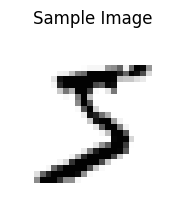

In [3]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

In [4]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

targetimage = feature_scale(targetimage, scaled=True)

In [5]:
targetimage = targetimage.flatten().astype(np.float64)
pixels = len(targetimage)
xcoordinates = np.arange(0, pixels).astype(np.float64)

In [6]:
def predict(x, ampweights, periodweights, horizonalweights, wave_samples, epsilon=1e-15): # all are vectors
    coordinates = len(x)
    xmat = np.repeat(x, wave_samples).reshape((-1, wave_samples))
    ampweightsmat = np.tile(ampweights, coordinates).reshape((coordinates, -1))
    periodweightsmat = np.tile(periodweights, coordinates).reshape((coordinates, -1))
    horizonalweightsmat = np.tile(horizonalweights, coordinates).reshape((coordinates, -1))
    
    combined_waves = ampweightsmat * np.sin(xmat * periodweightsmat + horizonalweightsmat)
    summed_waves = np.sum(combined_waves,axis=1)

    return summed_waves # vector

In [7]:
def inference(x, ampweights, periodweights, horizonalweights, wave_samples):
    prediction = predict(x, ampweights, periodweights, horizonalweights, wave_samples)
    return np.clip(prediction, 0.0, 1.0)

In [8]:
def mse_cost(x, y, ampweights, periodweights, horizonalweights, wave_samples):
    coordinates = len(x)
    prediction = predict(x, ampweights, periodweights, horizonalweights, wave_samples)
    error = prediction - y

    return np.dot(error, error) / (2*coordinates)

In [9]:
def compute_gradients(x, y, ampweights, periodweights, horizonalweights, wave_samples):
    coordinates = len(x)
    xmat = np.repeat(x, wave_samples).reshape((-1, wave_samples))
    ampweightsmat = np.tile(ampweights, coordinates).reshape((coordinates, -1))
    periodweightsmat = np.tile(periodweights, coordinates).reshape((coordinates, -1))
    horizonalweightsmat = np.tile(horizonalweights, coordinates).reshape((coordinates, -1))
    
    amp_partials =  np.sin(xmat * periodweightsmat + horizonalweightsmat)
    period_partials = xmat * ampweightsmat * np.cos(xmat * periodweightsmat + horizonalweightsmat)
    horizonal_partials = ampweightsmat * np.cos(xmat * periodweightsmat + horizonalweightsmat)

    prediction = predict(x, ampweights, periodweights, horizonalweights, wave_samples)
    error = prediction - y
    errorT = error.reshape((-1,1))

    daw = np.sum(errorT * amp_partials, axis=0) / coordinates
    dpw = np.sum(errorT * period_partials, axis=0) / coordinates
    dhw = np.sum(errorT * horizonal_partials, axis=0) / coordinates

    return daw, dpw, dhw

In [10]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    _, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Epoch")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

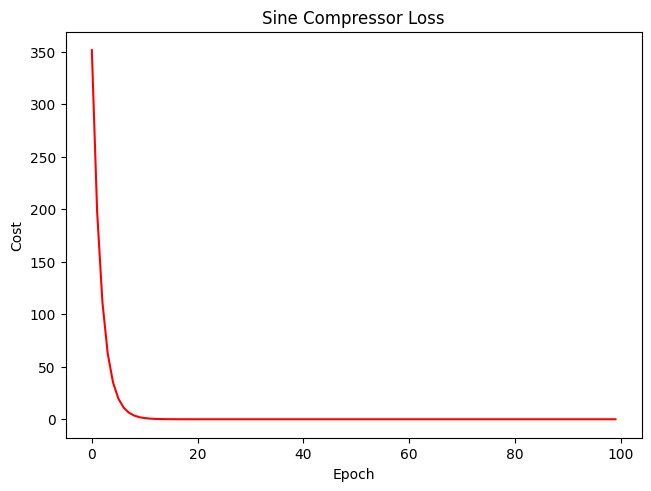

In [11]:
def gradient_descent(x, y, gradient_func, cost_func, wave_samples, learning_rate=0.01, max_iterations=1000):
    # ampweights = np.random.random(wave_samples)
    # periodweights = np.random.random(wave_samples)
    # horizonalweights = np.random.random(wave_samples)
    
    ampweights = np.ones(wave_samples)
    periodweights = np.ones(wave_samples)
    horizonalweights = np.zeros(wave_samples)

    costs = np.empty(0)

    for _ in range(max_iterations):
        daw,dpw,dhw = gradient_func(x, y, ampweights, periodweights, horizonalweights, wave_samples)

        ampweights -= learning_rate * daw
        periodweights -= learning_rate * dpw
        horizonalweights -= learning_rate * dhw
        
        current_cost = cost_func(x, y, ampweights, periodweights, horizonalweights, wave_samples)
        costs = np.append(costs, current_cost)
    return ampweights, periodweights, horizonalweights, costs
wave_samples = 50
ampweights, periodweights, horizonalweights, costs = gradient_descent(xcoordinates, targetimage, compute_gradients, mse_cost, wave_samples=wave_samples, learning_rate=0.01, max_iterations=100)
show_cost_graph(costs, "Sine Compressor Loss", "red")

Cost function is really bad. MSE on sine waves are most likely not convex so cost doesn't really improve after awhile.

In [12]:
print("Initial cost", costs[0])
print("Final cost", costs[-1])

Initial cost 351.33159329319386
Final cost 0.05820818206344424


In [13]:
predicted_image = inference(xcoordinates, ampweights, periodweights, horizonalweights, wave_samples)

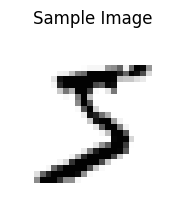

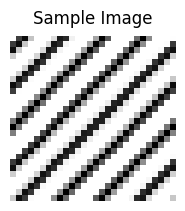

In [14]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

Using sum of sine waves as regression doesn't work as the cost function isn't exactly convex. In fact, after some research, there is no easy way to use a convex version for the cost function. So this is why it can't represent the full image. Next thing is to use fourier series as feature engineering and linear regression to achieve image compression. 